## Feature Information
**datetime** : Waktu ketika data dihitung (dalam format timestamp UNIX).

**datetime_iso** : Waktu dalam format ISO 8601, termasuk zona waktu.

**time-zone** : Zona waktu dalam detik terhadap UTC.

**temp** : Suhu saat ini dalam Celcius.

**visibility** : Visibilitas rata-rata dalam meter.

**d_point** : Titik embun saat ini dalam Celcius.

**feels** : Suhu yang dirasakan saat ini dalam Celcius.

**min_temp** : Suhu minimum dalam rentang waktu tertentu dalam Celcius.

**max_temp** : Suhu maksimum dalam rentang waktu tertentu dalam Celcius.

**pressure** : Tekanan atmosfer dalam hPa .

**sea_level** : Tekanan atmosfer pada permukaan laut dalam hPa.

**grnd_level** : Tekanan atmosfer pada permukaan tanah dalam hPa.

**hum** : Persentase kelembaban udara saat ini.

**wind_spd** : Kecepatan angin saat ini dalam m/s.

**wind_deg** : Arah angin dalam derajat.

**rain_1h** : Curah hujan dalam 1 jam terakhir dalam mm. (variabel target)

**rain_3h** : Curah hujan dalam 3 jam terakhir dalam mm.

**snow_1h** : Curah salju dalam 1 jam terakhir dalam mm.

**snow_3h** : Curah salju dalam 3 jam terakhir dalam mm.

**clouds** : Persentase penutupan awan saat ini.

In [1]:
import pandas as pd #untuk data handling
import numpy as np #untuk operasi statistik
import pickle #untuk menyimpan model
from sklearn.preprocessing import MinMaxScaler #scaling data
import re #untuk ekstraksi angka dari data objec

import matplotlib.pyplot as plt #visualisasi data
import seaborn as sns #visualisasi data

import pywt #untuk analisis spektralt
from sklearn.metrics import r2_score,mean_squared_error #metrics penilaian
import lightgbm as lgb #model yang digunakan

RANDOM_STATE = 98

In [2]:
#ambil data train dan test
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [4]:
#berapa persen data hilang dari setiap fitur
train.isnull().sum()/len(train)

datetime        0.000000
datetime_iso    0.000000
time-zone       0.000000
temp            0.000000
visibility      0.850497
d_point         0.000000
feels           0.000000
min_temp        0.000000
max_temp        0.000000
prssr           0.000000
sea_level       0.435580
grnd_level      0.435711
hum             0.000000
wind_spd        0.000000
wind_deg        0.000000
rain_1h         0.000000
rain_3h         0.437437
snow_1h         0.436364
snow_3h         0.436355
clouds          0.000000
dtype: float64

## Merubah jenis data
Mengekstraksi angka dari data object atau string menjadi float dan merubah type data menjadi yang seharusnya

In [5]:
train.dtypes

datetime         int64
datetime_iso    object
time-zone        int64
temp            object
visibility      object
d_point         object
feels           object
min_temp        object
max_temp        object
prssr           object
sea_level       object
grnd_level      object
hum             object
wind_spd        object
wind_deg        object
rain_1h         object
rain_3h         object
snow_1h         object
snow_3h         object
clouds          object
dtype: object

In [6]:
def fix_type(dataset,train_cek=True):
    pola = r'-?\d+\.?\d*'
    kolom = ['temp','d_point','feels','min_temp','max_temp','prssr','hum','wind_spd','wind_deg','clouds']
    for kol in kolom:
        dataset[kol] = [float(re.search(pola,str(x)).group()) if re.search(pola,str(x)) else 0.0 for x in dataset[kol]]
    dataset = dataset.drop(['datetime','time-zone'],axis=1)
    dataset['datetime_iso'] = pd.to_datetime(dataset['datetime_iso'])
    if train_cek:
        dataset['rain_1h'] = [float(re.search(pola,str(x)).group()) if re.search(pola,x) else 0.0 for x in dataset['rain_1h']] 
        dataset['rain_1h'] = [x if x >= 0 else 0.0 for x in dataset['rain_1h']] 
    return dataset

In [7]:
train_jenis_benar = fix_type(train)
test_jenis_benar = fix_type(test,False)

In [8]:
train_jenis_benar.dtypes

datetime_iso    datetime64[ns, UTC]
temp                        float64
visibility                   object
d_point                     float64
feels                       float64
min_temp                    float64
max_temp                    float64
prssr                       float64
sea_level                    object
grnd_level                   object
hum                         float64
wind_spd                    float64
wind_deg                    float64
rain_1h                     float64
rain_3h                      object
snow_1h                      object
snow_3h                      object
clouds                      float64
dtype: object

## Ekstrak data tanggal
Mengambil fitur bulan, tanggal, jam, minggu, hari, dan tahun dari fitur datetime_iso yang selanjutnya bisa dijadikan fitur tambahan

In [9]:
train_jenis_benar['datetime_iso'].head()

0   1979-01-01 00:00:00+00:00
1   1979-01-01 01:00:00+00:00
2   1979-01-01 02:00:00+00:00
3   1979-01-01 03:00:00+00:00
4   1979-01-01 04:00:00+00:00
Name: datetime_iso, dtype: datetime64[ns, UTC]

In [10]:
def date_extract(dataset):
    dataset['bulan'] = [x.month for x in dataset['datetime_iso']]
    dataset['tanggal'] = [x.day for x in dataset['datetime_iso']]
    dataset['jam'] = [x.hour for x in dataset['datetime_iso']]
    dataset['minggu'] = [x.week for x in dataset['datetime_iso']]
    dataset['hari'] = [x.dayofweek for x in dataset['datetime_iso']]
    dataset['tahun'] = [x.year for x in dataset['datetime_iso']]
    dataset = dataset.drop('datetime_iso',axis=1)
    return dataset

In [11]:
train_ekstrak_tanggal = date_extract(train_jenis_benar)
test_ekstrak_tanggal = date_extract(test_jenis_benar)

In [12]:
train_ekstrak_tanggal[['bulan','tanggal','jam','minggu','hari','tahun']].head()

,bulan,tanggal,jam,minggu,hari,tahun
0,1,1,0,1,0,1979
1,1,1,1,1,0,1979
2,1,1,2,1,0,1979
3,1,1,3,1,0,1979
4,1,1,4,1,0,1979


## Atasi Outlier
Mengelompokkan data tidak biasa menjadi satu nilai yang jauh dari persebaran normal. Ini dilakukan dengan asumsi bahwa outlier mempunyai pola
* temp, feels, min_temp, max_temp = tidak mungkin suhu lingkungan mencapai 100 derajat celsius lebih
* d_point = tidak mungkin titik embun melebihi 80 derajat celsius
* prssr = tidak mungkin tekana melebihi 2000 hPa
* hum = tidak mungkin persentasi humiditas melebihi 100 persen
* wind_spd = tidak mungkin kecepatan angin melebihi 10m/s
* wind_deg = membatasi derajat hanya sampai 360 derajat

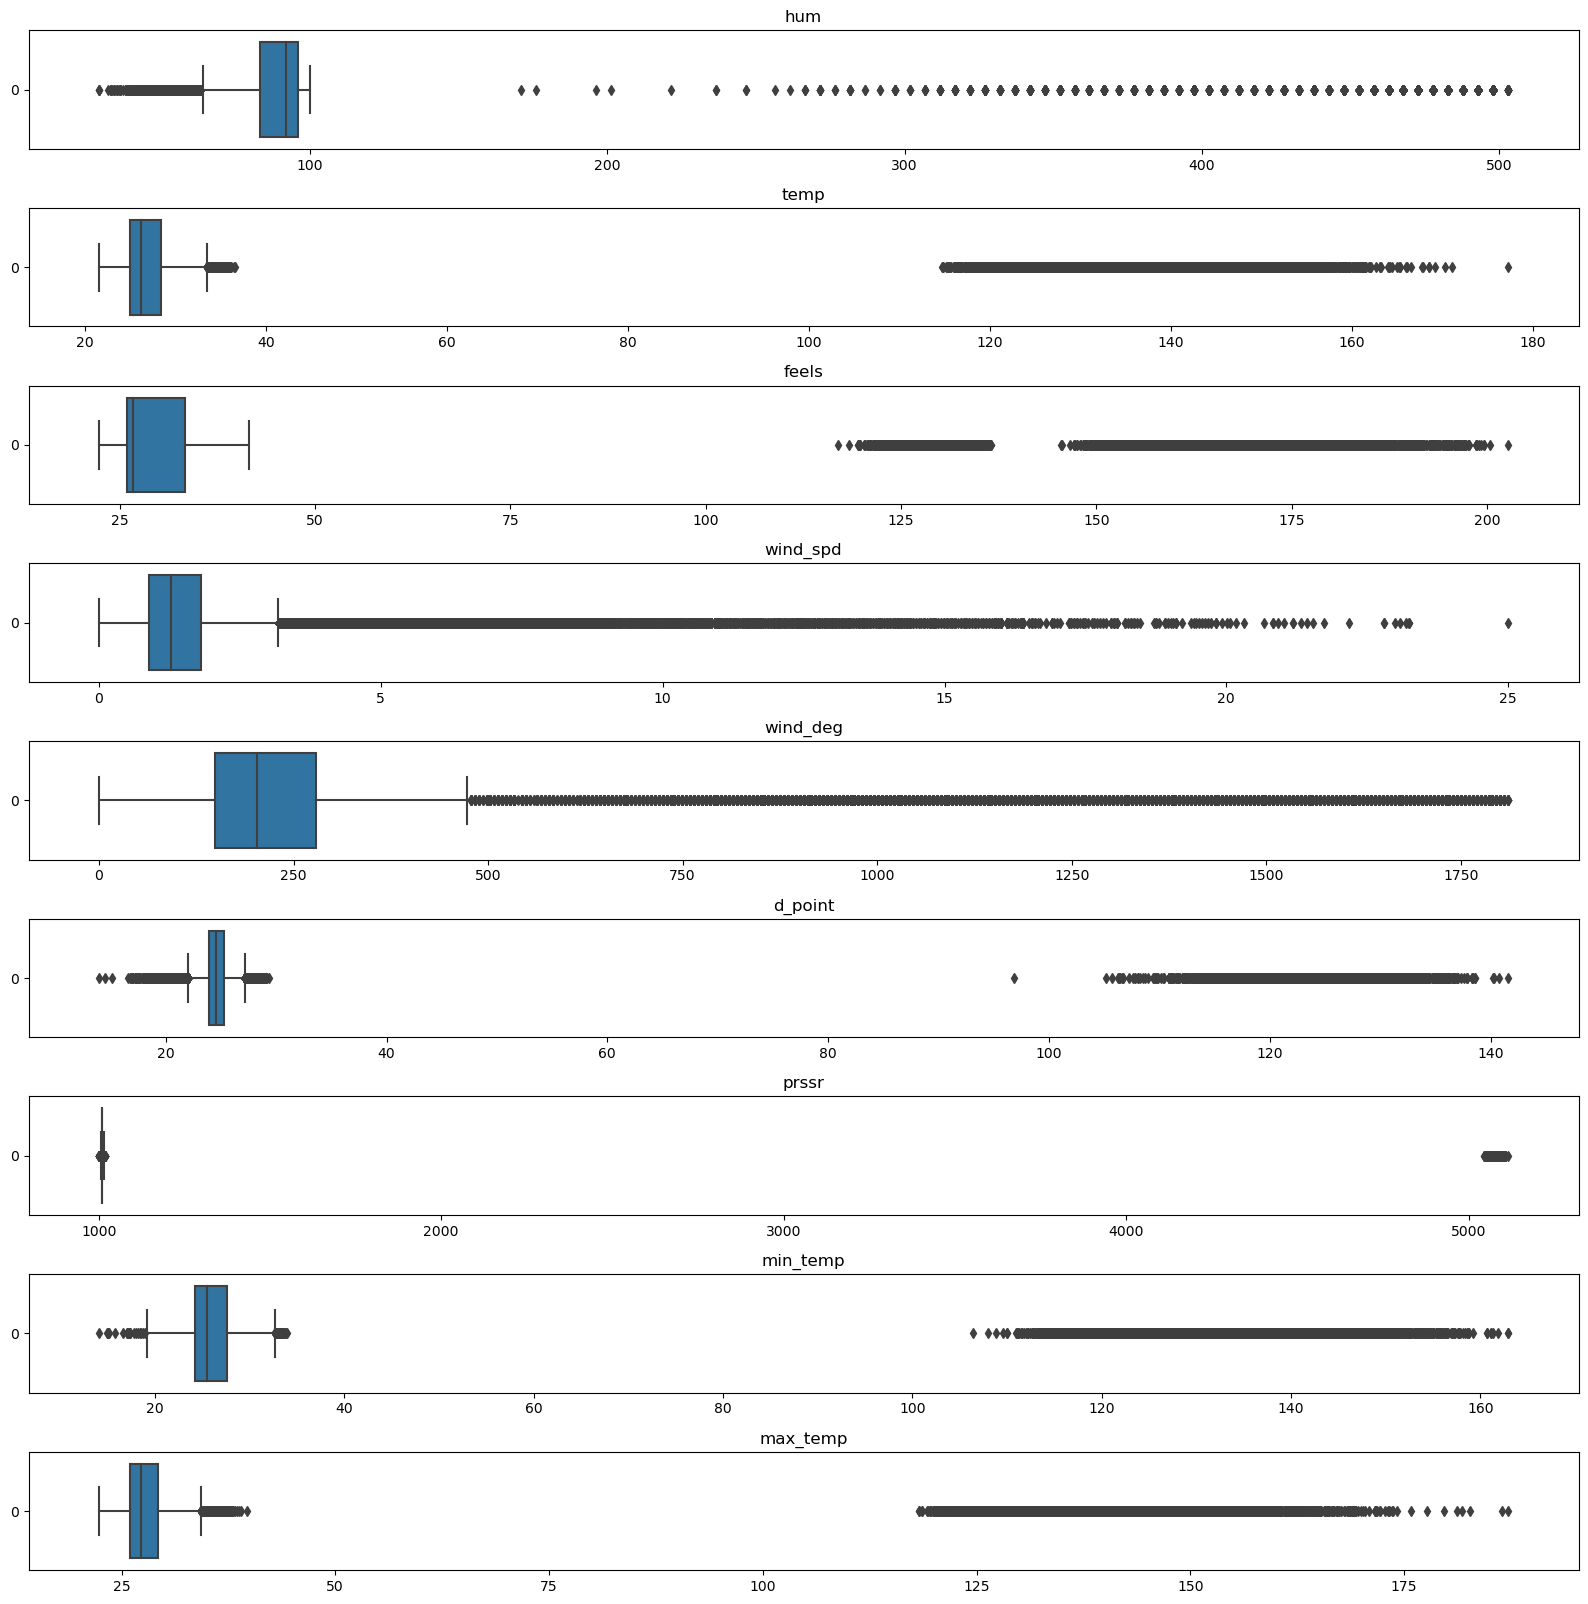

In [13]:
fig, ax = plt.subplots(9,1,figsize=(20,20),gridspec_kw={'hspace': 0.5})
for y,x in enumerate(['hum','temp','feels','wind_spd','wind_deg','d_point','prssr','min_temp','max_temp']):
    sns.boxplot(train_ekstrak_tanggal[x],ax=ax[y],orient="h")
    ax[y].set_title(x)

In [14]:
def remove_outlier(dataset):    
    dataset['temp'] = [99 if x > 100 else x for x in dataset['temp']]
    dataset['d_point'] = [99 if x > 80 else x for x in dataset['d_point']]
    dataset['feels'] = [99 if x >100 else x for x in dataset['feels']]
    dataset['min_temp'] = [99 if x >100 else x for x in dataset['min_temp']]
    dataset['max_temp'] = [99 if x >100 else x for x in dataset['max_temp']]
    dataset['prssr'] = [1099 if x >2000 else x for x in dataset['prssr']]
    dataset['hum'] = [99 if x >100 else x for x in dataset['hum']]
    dataset['wind_spd'] = [19 if x >10 else x for x in dataset['wind_spd']]
    dataset['wind_deg'] = [x%360 if x >360 else x for x in dataset['wind_deg']]
    return dataset

In [15]:
train_ro = remove_outlier(train_ekstrak_tanggal)
test_ro = remove_outlier(test_ekstrak_tanggal)

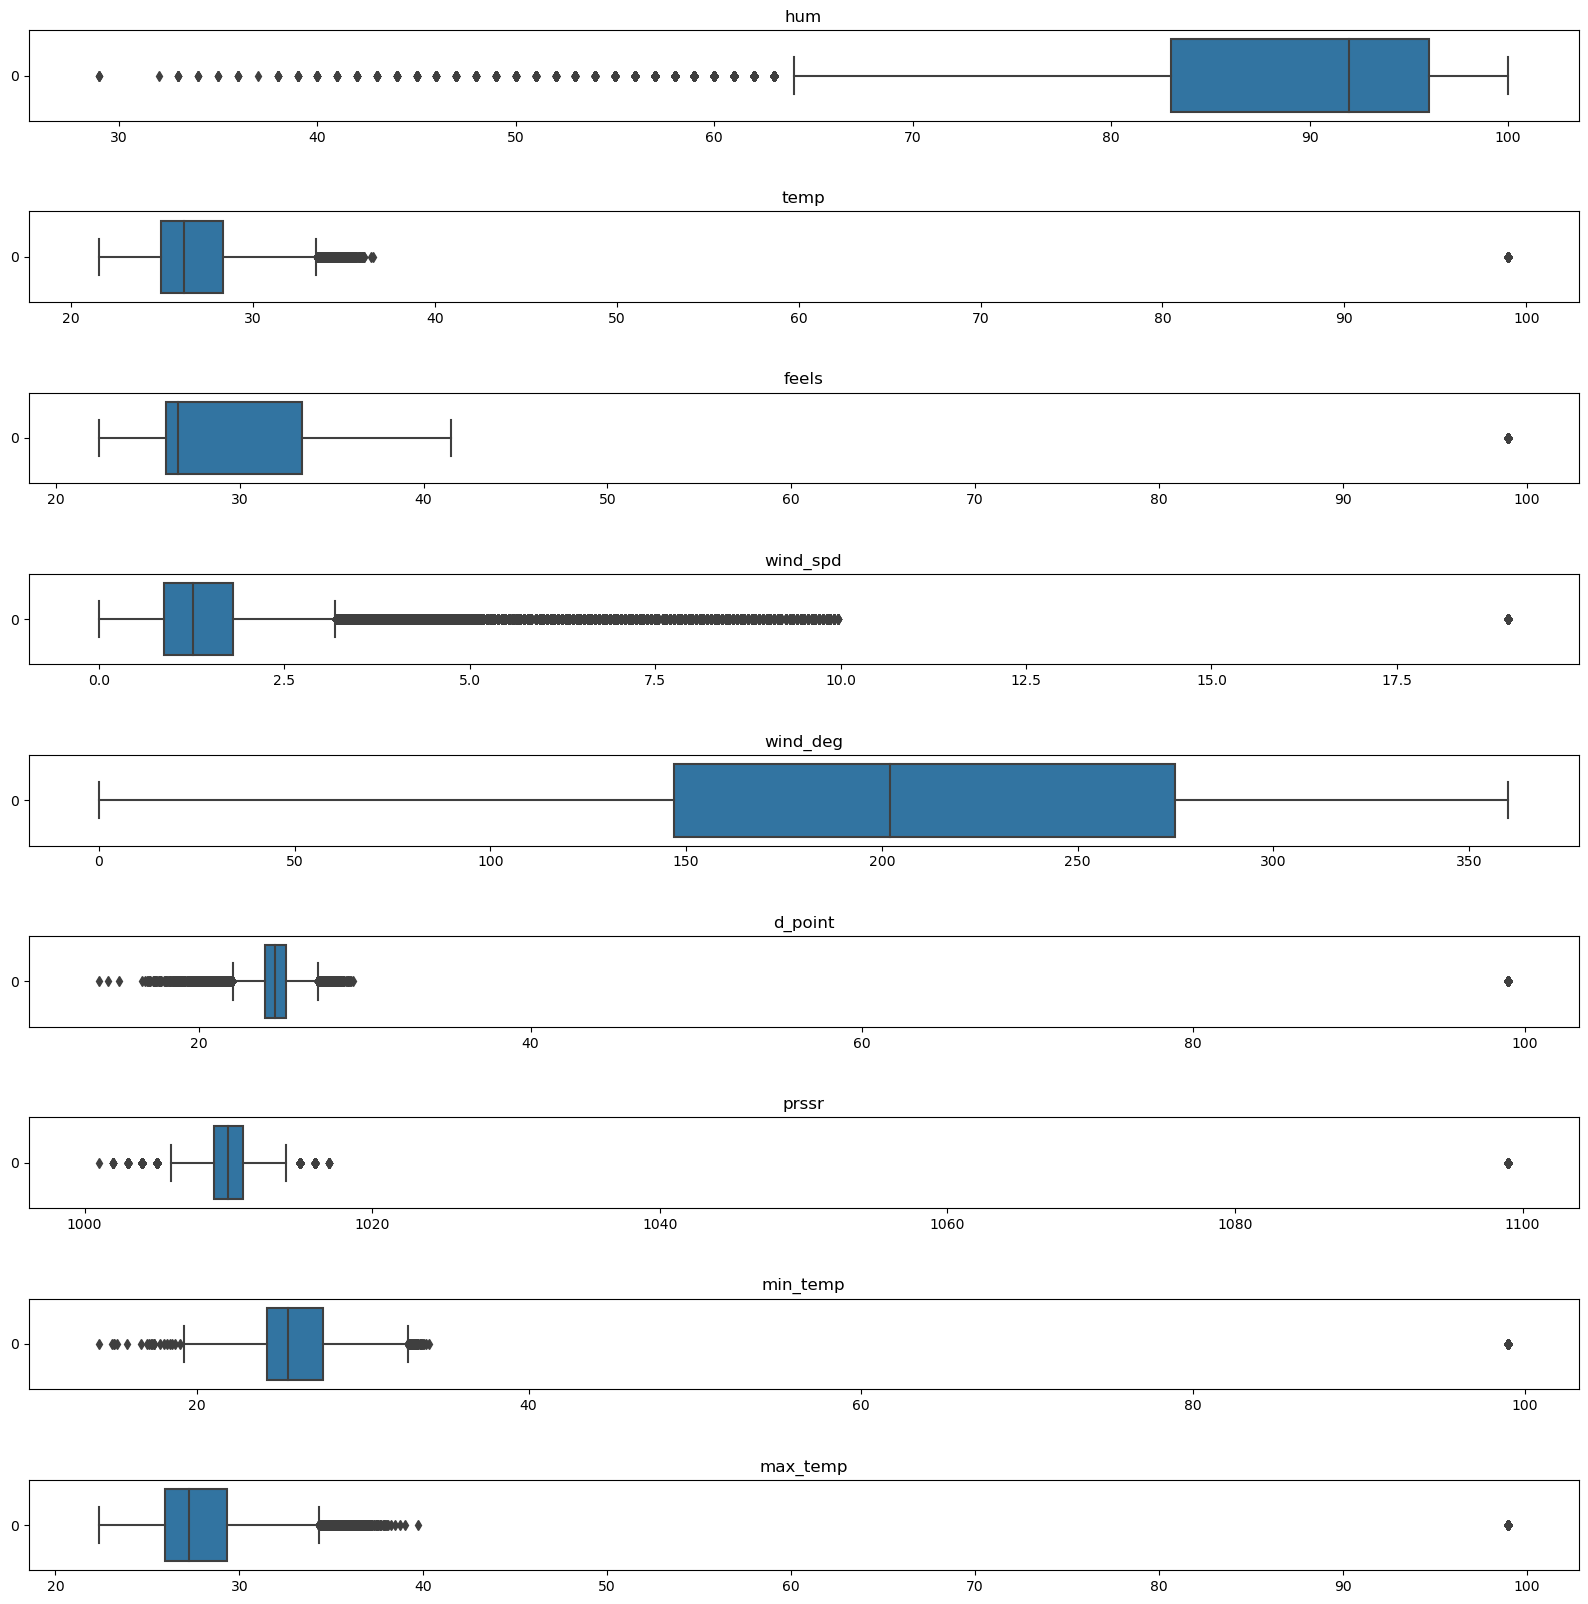

In [16]:
fig, ax = plt.subplots(9,1,figsize=(20,20),gridspec_kw={'hspace': 1.0})
for y,x in enumerate(['hum','temp','feels','wind_spd','wind_deg','d_point','prssr','min_temp','max_temp']):
    sns.boxplot(train_ro[x],ax=ax[y],orient="h")
    ax[y].set_title(x)

## Feature Creation
Membuat fitur dengan analisis statistik dan analisis spectral untuk mengekstrak pola dari data

In [17]:
def move_average(dataset):
    dataset = dataset.copy()
    kol_add = []
    
    # ANALISIS STATISTIK
    for x in ['hum','d_point','temp']: #Standar deviasi
        dataset[x+f'_std'] = dataset[x].rolling(window=2).std()
        kol_add.append(x+f'_std')
    for x in ['hum','temp','feels','wind_spd','clouds','d_point','prssr']: #Persentase perubahan
        for y in range(1,4):
            dataset[x+f'_pct_change_{y}'] = dataset[x].pct_change(y)
            kol_add.append(x+f'_pct_change_{y}')
    for x in ['hum','d_point','wind_spd','clouds']: #Fitur Lag
        for y in range(1,2):
            dataset[x+f'_lag_{y}'] = dataset[x].shift(y)
            kol_add.append(x+f'_lag_{y}')
            
    #ANALISIS SPEKTRAL
    for x in ['hum','temp','d_point']:
        dataset[x+f'_fourier'] = np.abs(np.fft.fft(dataset[x])) #Fourier Wavelet
    for y,x in enumerate(['d_point','wind_spd','wind_deg']):
        scales = [8,1,4]
        morl,_ = pywt.cwt(dataset[x], scales[y], 'morl') #Morlet Wavelet
        dataset[x+f'_morl'] = morl[0]
    for x in ['hum']:
        morl,_ = pywt.cwt(dataset[x], 1, 'morl') #Morlet Wavelet
        mexh,_ = pywt.cwt(dataset[x], 5, 'mexh') #Mexican Hat Wavelet
        gaus,_ = pywt.cwt(dataset[x], 1, f'gaus7') #Gaussian Derivative Wavelets
        cgau,_ = pywt.cwt(dataset[x], 3, f'cgau2') #Complex Gaussian Derivative Wavelets
        cmor,_ = pywt.cwt(dataset[x], 13, f'cmor0.5-1.0') #Complex Morlet Wavelets
        shan,_ = pywt.cwt(dataset[x], 12, f'shan-1.0-1.0') #Shannon Wavelets
        dataset[x+f'_shan'] = np.abs(shan[0])
        dataset[x+f'_cgau'] = np.abs(cgau[0])
        dataset[x+f'_cmor'] = np.abs(cmor[0])
        dataset[x+f'_gaus'] = gaus[0]
        dataset[x+f'_morl'] = morl[0]
        dataset[x+f'_mexh'] = mexh[0]
    for y,x in enumerate(['hum_gaus','hum_cgau','hum_shan']): #Simple moving average untuk fitur wavelet
        windows = [3,7,10]
        dataset[x+f'_sma'] = dataset[x].rolling(window=windows[y]).mean()
        kol_add.append(x+f'_sma')
    for x in ['hum_mexh','hum_morl']: #Simple moving average dan standar deviasi untuk fitur wavelet
        dataset[x+f'_sma'] = dataset[x].rolling(window=6).mean()
        kol_add.append(x+f'_sma')
        dataset[x+f'_std'] = dataset[x].rolling(window=4).std()
        kol_add.append(x+f'_std')
    dataset[kol_add] = dataset[kol_add].fillna(method='bfill')
    return dataset

In [18]:
def optimize_bc(dataset,a,b):
    '''
    Untuk mencari sigma dan beta yang optimal dalam transformasi wavelet:
    
    "σ" (sigma): Parameter ini mengontrol lebar dari wavelet dalam domain waktu. 
        Nilai sigma yang lebih besar akan menghasilkan wavelet yang lebih lebar.
    "β" (beta): Parameter ini mengontrol aspek dari skala bandwidth dalam domain frekuensi. 
        Nilai beta yang lebih besar akan menghasilkan wavelet dengan bandwidth frekuensi yang lebih lebar
        
    '''
    optimum = {'sigma':[],'beta':[],'score':[]}
    track  = 1
    for x in a:
        for y in b:
            optimum['sigma'].append(x)
            optimum['beta'].append(y)
            dataset = move_average(dataset,x,y)
            kol_na = [x for x in dataset.columns if dataset[x].isna().sum() > 0]
            dataset.drop(kol_na,axis=1,inplace=True)
            X_train, X_test, y_train, y_test = train_test_split(dataset.drop('rain_1h',axis=1),
                                                    dataset['rain_1h'], test_size=0.2, random_state=RANDOM_STATE)
            lgb_m = lgb.LGBMRegressor(learning_rate=0.16,n_jobs=-1,n_estimators=900,boosting_type='dart',
                              max_depth=11,num_leaves=55,random_state=RANDOM_STATE)
            lgb_m.fit(X_train, y_train)
            pred = lgb_m.predict(X_test)
            r2 = r2_score(y_test,pred)
            optimum['score'].append(r2)
            print(f'iterasi ke-{track} dengan parameter {x}, {y} dan score {r2}')
            track += 1
    optimum = pd.DataFrame(optimum)
    return optimum

In [19]:
def optimize_scale(dataset,a):
    '''
    Mencari scale yang optimal pada transformasi wavelet
    scale: Ini adalah skala wavelet yang akan digunakan dalam transformasi CWT. 
        Skala ini mengendalikan lebar wavelet dan pengaruhnya pada data. 
        Semakin tinggi skala, semakin "besar" wavelet-nya, 
        yang berarti akan mendeteksi fitur frekuensi yang lebih rendah dalam data. 
        Sedangkan semakin rendah skala, semakin "kecil" wavelet-nya, 
        yang berarti akan mendeteksi fitur frekuensi yang lebih tinggi dalam data
    '''
    optimum = {'scale':[],'score':[]}
    track = 1
    for x in a:
        optimum['scale'].append(x)
        dataset = move_average(dataset,x)
        kol_na = [x for x in dataset.columns if dataset[x].isna().sum() > 0]
        dataset.drop(kol_na,axis=1,inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(dataset.drop('rain_1h',axis=1),
                                                            dataset['rain_1h'], test_size=0.2, random_state=RANDOM_STATE)
        lgb_m = lgb.LGBMRegressor(learning_rate=0.161,n_jobs=-1,n_estimators=905,boosting_type='dart',
                              max_depth=11,num_leaves=55,random_state=RANDOM_STATE)
        lgb_m.fit(X_train, y_train)
        pred = lgb_m.predict(X_test)
        r2 = r2_score(y_test,pred)
        optimum['score'].append(r2)
        print(f'iterasi ke-{track} dengan parameter {x} dan score {r2}')
        track += 1
    optimum = pd.DataFrame(optimum)
    return optimum

In [20]:
# a = np.arange(1,21)
# optimal = optimize_scale(train_ro,a)

In [21]:
# optimal = optimal.sort_values(by='score',ascending=False)
# optimal

In [22]:
train_ma = move_average(train_ro)
test_ma = move_average(test_ro)

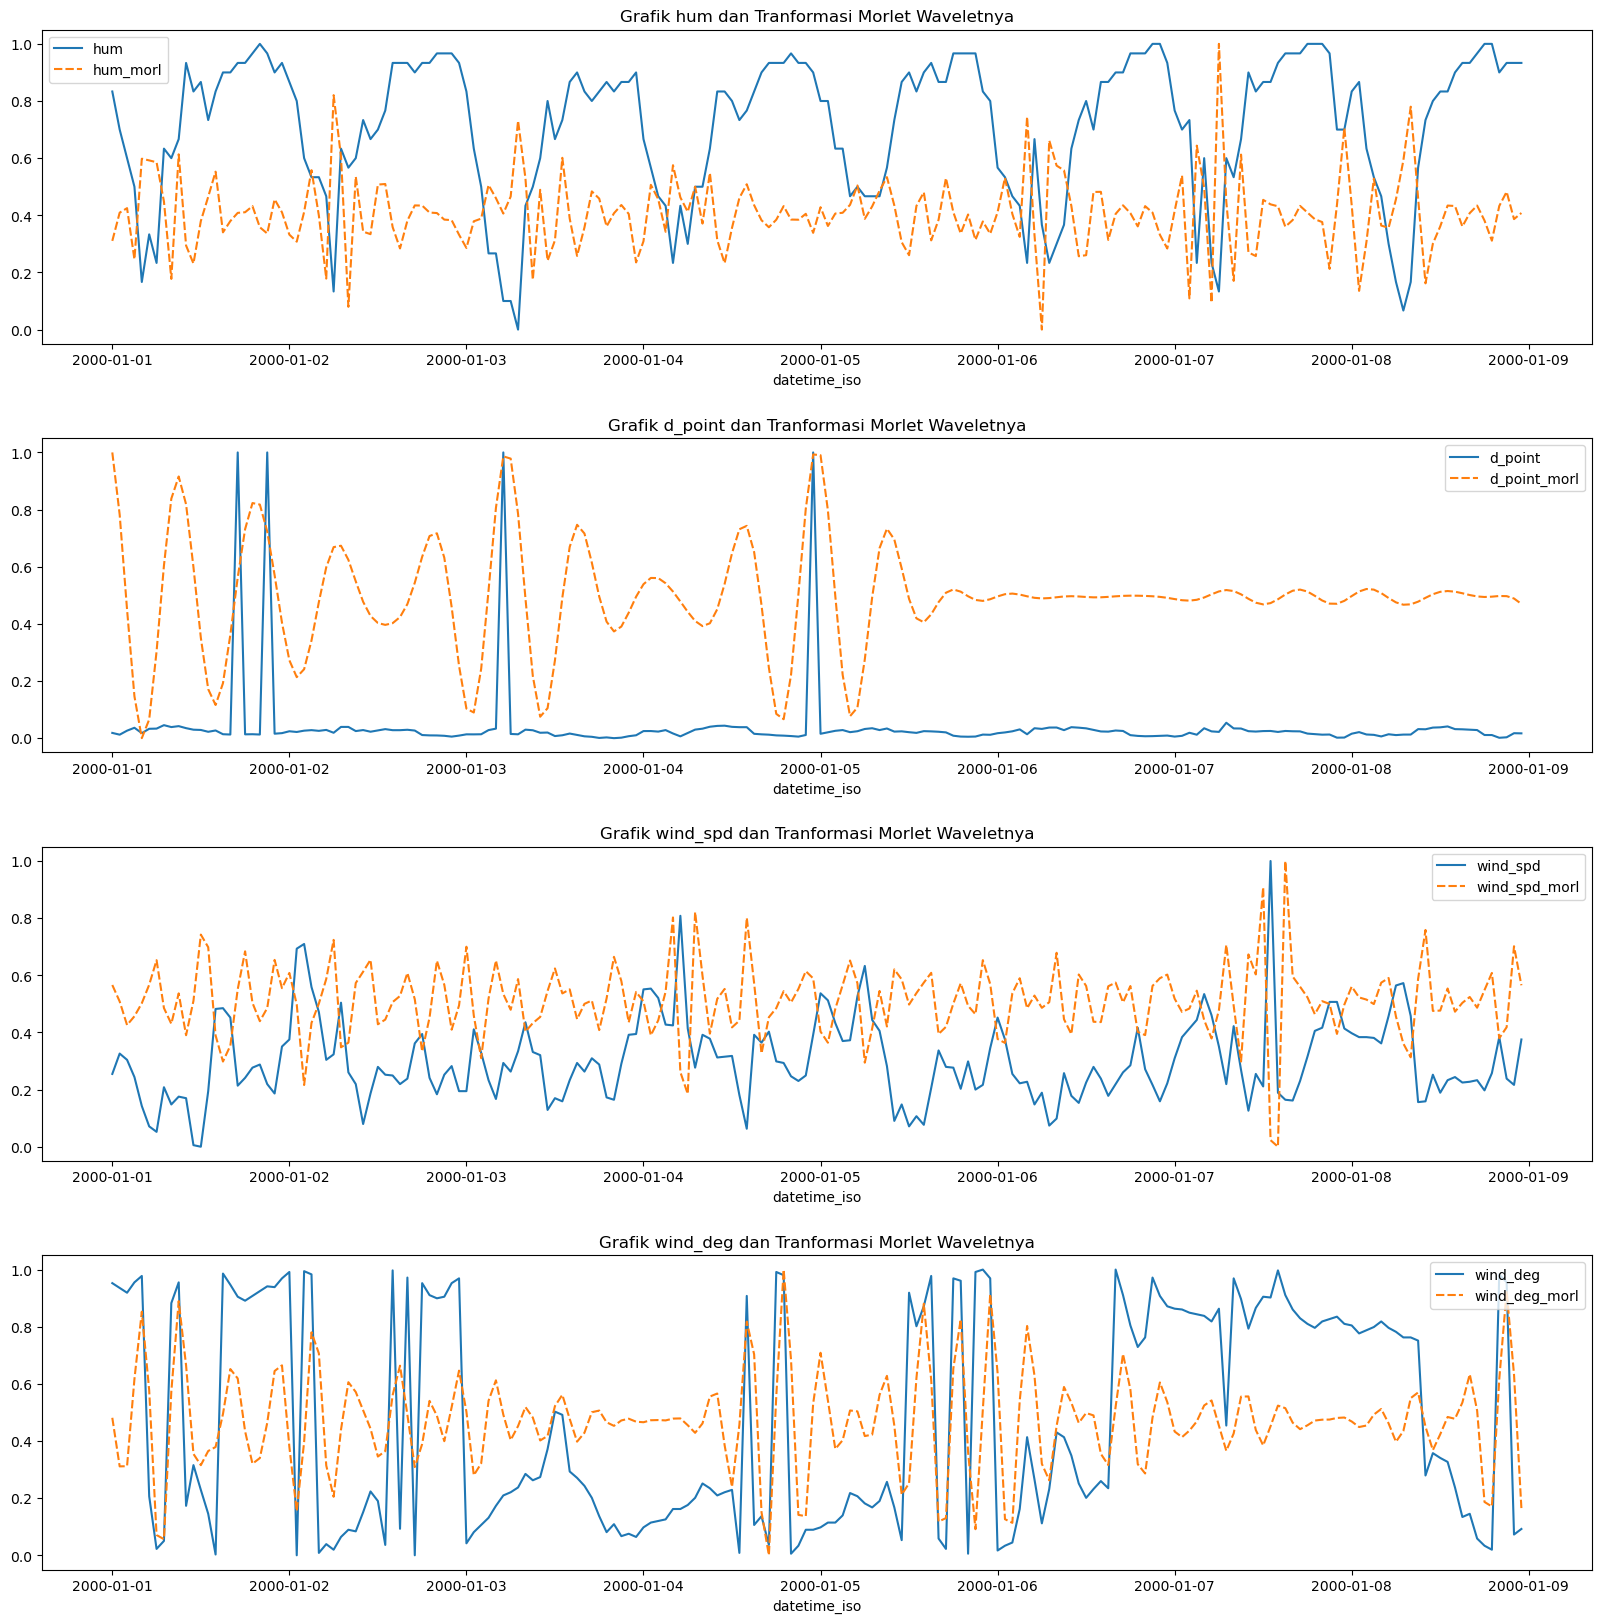

In [23]:
mms = MinMaxScaler()
mms.set_output(transform='pandas')
col = ['hum','d_point','wind_spd','wind_deg','hum_morl','d_point_morl','wind_spd_morl','wind_deg_morl']
toplot = pd.concat([train_jenis_benar['datetime_iso'],train_ma[col]],axis=1).set_index('datetime_iso')
toplot = mms.fit_transform(toplot['2000-01-01':'2000-01-08'])

fig, ax = plt.subplots(4,1,figsize=(20,20),gridspec_kw={'hspace': 0.3})
for y,x in enumerate(col[:4]):
    graph = toplot[[x,x+'_morl']]
    sns.lineplot(graph,ax=ax[y])
    ax[y].set_title(f'Grafik {x} dan Tranformasi Morlet Waveletnya')
#     ax[y].set_xticks(rotation=45)

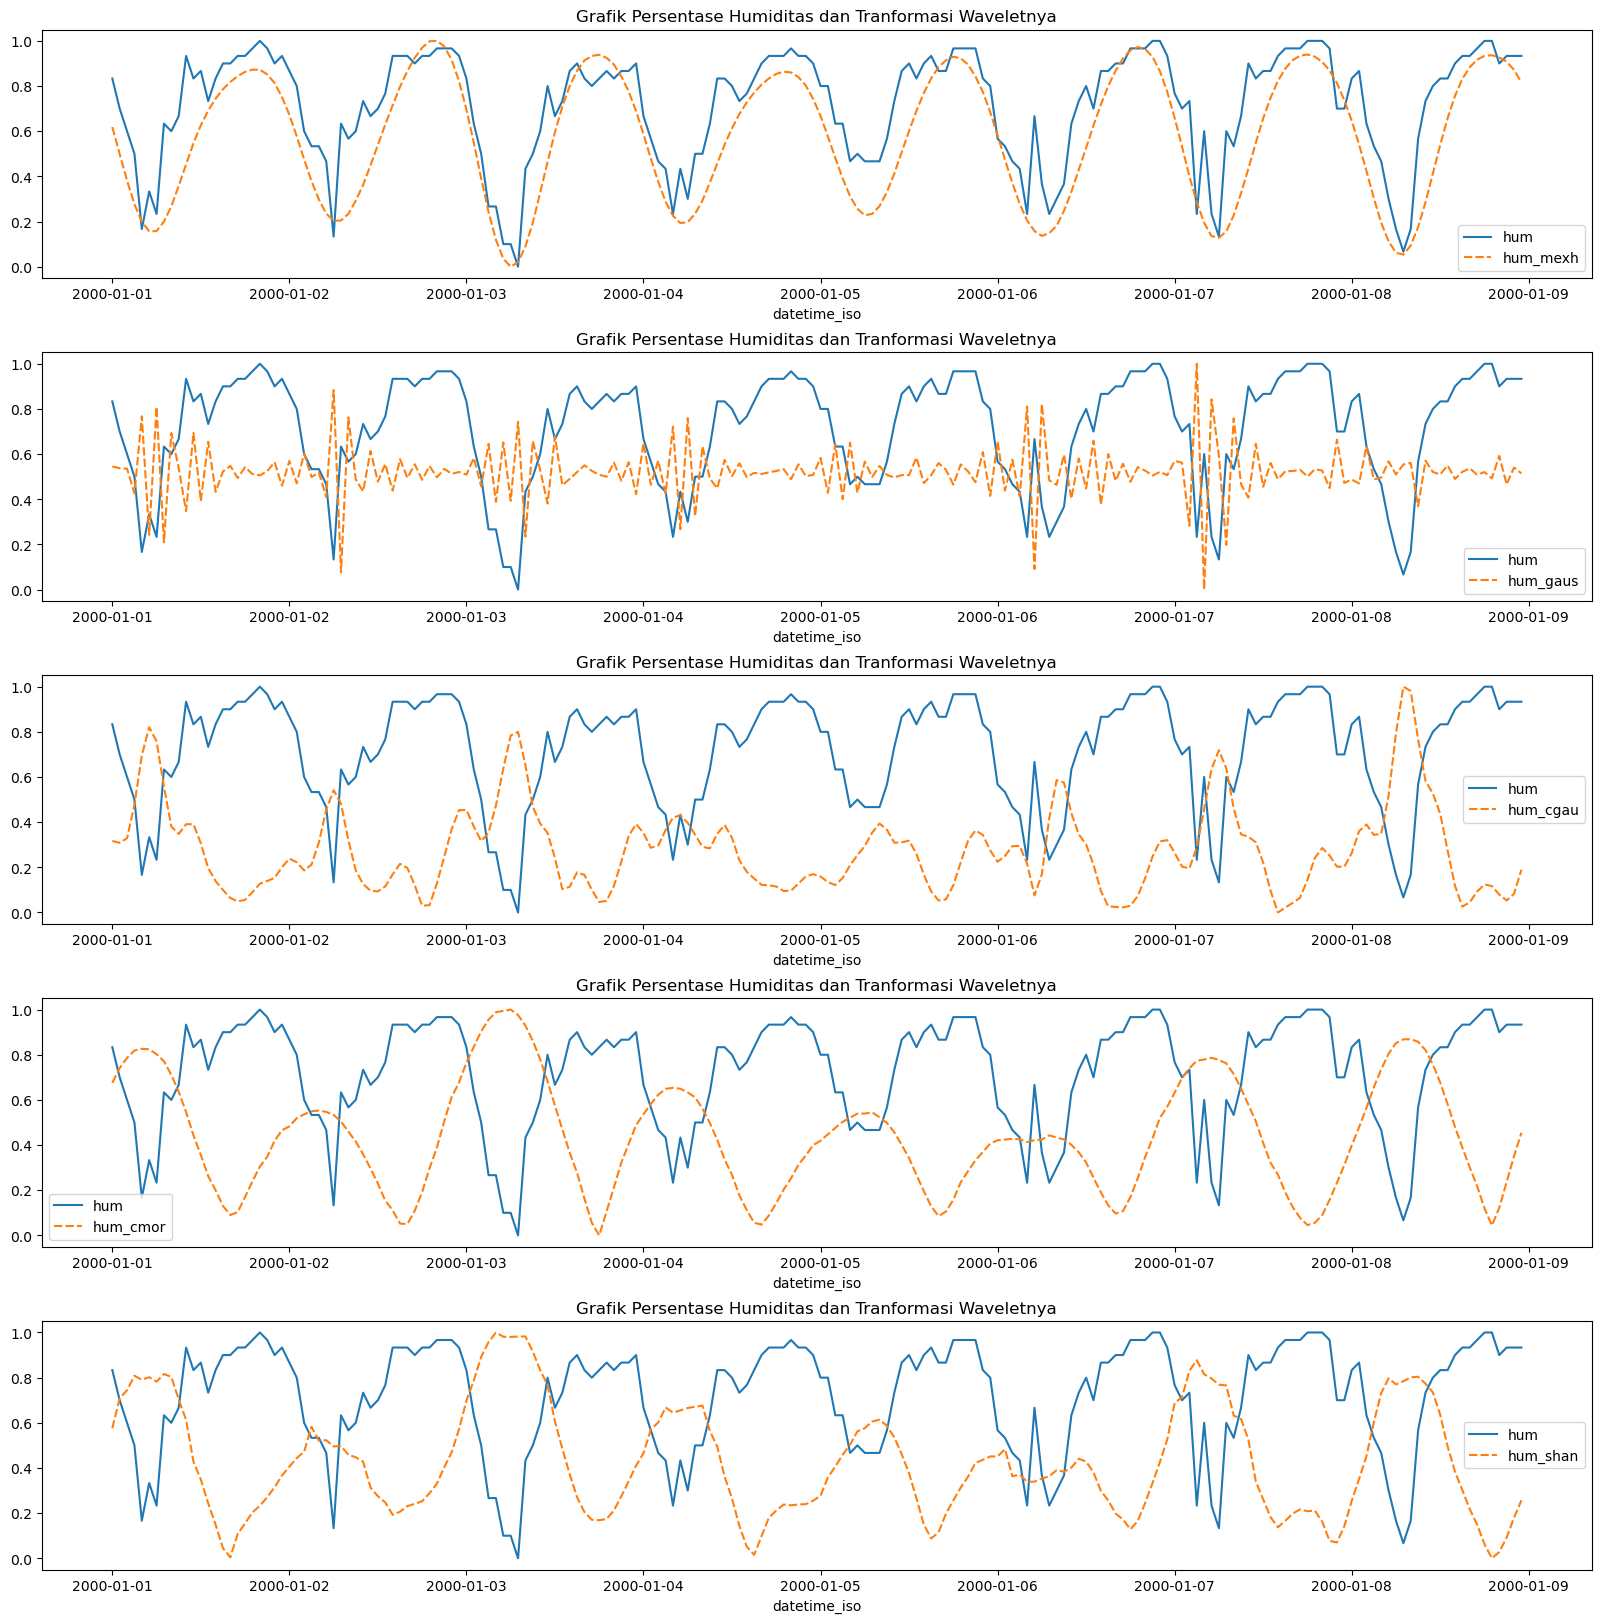

In [24]:
mms = MinMaxScaler()
mms.set_output(transform='pandas')
col = ['hum','hum_mexh','hum_gaus','hum_cgau','hum_cmor','hum_shan']
toplot = pd.concat([train_jenis_benar['datetime_iso'],train_ma[col]],axis=1).set_index('datetime_iso')
toplot = mms.fit_transform(toplot['2000-01-01':'2000-01-08'])

fig, ax = plt.subplots(5,1,figsize=(20,20),gridspec_kw={'hspace': 0.3})
for y,x in enumerate(col[1:]):
    graph = toplot[['hum',x]]
    sns.lineplot(graph,ax=ax[y])
    ax[y].set_title(f'Grafik Persentase Humiditas dan Tranformasi Waveletnya')

## Atasi data kosong
Data kosong yang terlalu banyak dan kategori yang tunggal akan dihapus

In [25]:
kol_na = [x for x in train_ma.columns if train_ma[x].isna().sum() > 0]
kol_na

['visibility', 'sea_level', 'grnd_level', 'rain_3h', 'snow_1h', 'snow_3h']

In [26]:
train_ma[kol_na].isna().sum()/len(train_ma)

visibility    0.850497
sea_level     0.435580
grnd_level    0.435711
rain_3h       0.437437
snow_1h       0.436364
snow_3h       0.436355
dtype: float64

In [27]:
train_ma['visibility'].unique()

array([nan, 'unidentified', ' ', '-1m', 'unrecognized', 'unknown',
       '-1 km', '-1', 'empty', 'undefined', '-1km', '-1 m', 'missing'],
      dtype=object)

In [28]:
train_ma['sea_level'].unique()

array(['undetermined', nan, 'unsettled', 'unestablished', '-1',
       'not recorded', 'unknown', 'not_recorded', 'not-recorded',
       'unspecified'], dtype=object)

In [29]:
train_ma['grnd_level'].unique()

array([nan, 'undetermined', 'not recorded', 'unspecified', 'unknown',
       'not_recorded', '-1', 'unestablished', 'not-recorded', 'unsettled'],
      dtype=object)

In [30]:
train_ma['rain_3h'].unique()

array(['0', 'volume:zero', 'nol', nan, 'zero', '0 mm', '0 milimeter',
       'no_rain', 'no-rain', 'volume:0', '0mm'], dtype=object)

In [31]:
train_ma['snow_1h'].unique()

array([nan, '0', 'nol', 'volume:zero', '0mm', '0 mm', 'volume:0', 'zero',
       '0 milimeter', 'no-snow', 'no_snow'], dtype=object)

In [32]:
train_ma['snow_3h'].unique()

array([nan, '0', 'no-snow', '0 mm', 'zero', 'volume:0', '0mm', 'no_snow',
       'volume:zero', '0 milimeter', 'nol'], dtype=object)

In [33]:
train_ma.drop(kol_na,axis=1,inplace=True)
test_ma.drop(kol_na,axis=1,inplace=True)

## Simpan Preprocessed train dan set

In [34]:
train_ma.to_csv('train_Optima.csv',sep=',',index=False)

In [35]:
test_ma.to_csv('test_Optima.csv',sep=',',index=False)

## Potong data dan target
Data yang sudah bersih dan diolah akan dibagi menjadi data train dan test

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train_ma.drop('rain_1h',axis=1),
                                                    train_ma['rain_1h'], test_size=0.2, random_state=RANDOM_STATE)

In [38]:
len(X_train.columns)

63

## Pembuatan Model
Digunakan model gradient boosting yaitu Light Gradient Bossting Machine

In [39]:
# R2 Score =  0.4311149028000172
# Mean Squared Error =  0.49898436371529026
# R2 Score =  0.435497335371263
# Mean Squared Error =  0.4951404146667892
# R2 Score =  0.4363933642677341
# Mean Squared Error =  0.49435448370994617
# R2 Score =  0.4392635304678967
# Mean Squared Error =  0.491836984021179
# R2 Score =  0.4435393693355707
# Mean Squared Error =  0.48808653116657486

In [40]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.161,n_jobs=-1,n_estimators=905,boosting_type='dart',
                              max_depth=11,num_leaves=55,random_state=RANDOM_STATE)
# lgb_model.fit(train_ma.drop('rain_1h',axis=1),train_ma['rain_1h'])
lgb_model.fit(X_train, y_train)
pred = lgb_model.predict(X_test)
r2 = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
print('Metrics prediksi model pada data test')
print('R2 Score = ',r2)
print('Mean Squared Error = ',mse)

Metrics prediksi model pada data test
R2 Score =  0.4435393693355707
Mean Squared Error =  0.48808653116657486


In [41]:
print('Metrics prediksi model pada data train')
print(mean_squared_error(y_train,lgb_model.predict(X_train)))

Metrics prediksi model pada data train
0.27934580892439415


In [52]:
#Tingkat penggunaan fitur dalam pembuatan model (Feature Importance)
feature_importance = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[:50]

,Feature,Importance
12,jam,3250
60,hum_mexh_std,1474
8,wind_deg,1310
6,hum,1271
48,wind_spd_morl,1238
38,prssr_pct_change_2,1192
7,wind_spd,1156
52,hum_cmor,1148
13,minggu,1140
42,wind_spd_lag_1,1136


In [43]:
#Prediksi pada data test
pred = lgb_model.predict(X_test)
lihat = pd.concat([pd.Series(y_test,name='Asli').reset_index(drop=True),pd.Series(np.round(pred,2),name='Prediksi')],axis=1)

In [44]:
lihat

,Asli,Prediksi
0,0.00,0.25
1,0.00,0.08
2,0.00,0.11
3,0.00,0.08
4,0.87,0.96
...,...,...
68371,0.00,-0.02
68372,0.55,1.33
68373,0.00,0.03
68374,0.00,-0.04


In [45]:
lihat[lihat['Prediksi']>3]

,Asli,Prediksi
14,1.08,3.44
19,3.17,3.65
214,8.49,3.93
342,2.57,3.45
412,9.30,3.89
...,...,...
68300,3.41,3.73
68323,3.01,3.08
68355,1.81,3.44
68365,6.38,4.63


## Simpan Model yang sudah difit

In [46]:
pickle.dump(lgb_model, open('model_Optima.pkl', 'wb'))

In [53]:
#Coba load model
with open('model_Optima.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [54]:
loaded_model.fit(X_train, y_train)
pred = loaded_model.predict(X_test)
r2 = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
print('Metrics prediksi model yang diload pada data test')
print('R2 Score = ',r2)
print('Mean Squared Error = ',mse)

Metrics prediksi model yang diload pada data test
R2 Score =  0.4435393693355707
Mean Squared Error =  0.48808653116657486


## Prediksi data test akhir

In [47]:
#Prediksi pada data test akhir
pred_coba = lgb_model.predict(test_ma)

In [48]:
final = pd.concat([test_jenis_benar['datetime_iso'],pd.Series(np.round(pred_coba,2),name='rain_1h')],axis=1)

In [49]:
final

,datetime_iso,rain_1h
0,2018-01-01 00:00:00+00:00,0.51
1,2018-01-01 01:00:00+00:00,0.29
2,2018-01-01 02:00:00+00:00,0.50
3,2018-01-01 03:00:00+00:00,0.14
4,2018-01-01 04:00:00+00:00,0.27
...,...,...
49363,2023-08-19 19:00:00+00:00,-0.02
49364,2023-08-19 20:00:00+00:00,0.00
49365,2023-08-19 21:00:00+00:00,-0.01
49366,2023-08-19 22:00:00+00:00,0.09


In [50]:
final[final['rain_1h'] > 2]

,datetime_iso,rain_1h
5,2018-01-01 05:00:00+00:00,2.17
6,2018-01-01 06:00:00+00:00,3.63
7,2018-01-01 07:00:00+00:00,2.04
55,2018-01-03 07:00:00+00:00,2.35
125,2018-01-06 05:00:00+00:00,3.84
...,...,...
48342,2023-07-08 06:00:00+00:00,5.08
48343,2023-07-08 07:00:00+00:00,2.95
48508,2023-07-15 04:00:00+00:00,2.64
48654,2023-07-21 06:00:00+00:00,3.06


In [51]:
#Simpan hasil prediksi pada file csv
final.to_csv('lgbm.csv',sep=',',index=False)